In [1]:
!nvidia-smi

Tue Feb 20 19:46:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P8              20W / 215W |    927MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
data_dir = '../data/heartsound/'
sr = 4000

x_train = np.load(f'{data_dir}preprocessed/heartsound.audio4k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}preprocessed/heartsound.audio4k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}preprocessed/heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.test.npy', allow_pickle=True)

In [9]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [10]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [37]:
del model
gc.collect()

10

In [39]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M13
description: FirConv with fftconv
fe:
  n_block: 2
  n_channel:
  - 64
  - 64
  kernel_size:
  - 511
  - 127
  stride:
  - 4
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: concat
  pooling: max
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer):

In [40]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [41]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [43]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  1%|█                                                                                                                                                                              | 0.05714285714285714/10 [00:00<01:12,  7.32s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.656172
Mem before-during-after: 19048960 636450816 34019328


 10%|█████████████████▌                                                                                                                                                              | 1.0000000000000002/10 [00:07<01:00,  6.67s/it]


Test Epoch: 1	Accuracy: 145/224 (63%)



 11%|██████████████████▌                                                                                                                                                             | 1.0571428571428572/10 [00:07<01:01,  6.89s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.652673
Mem before-during-after: 33946624 637544448 33958912


 20%|███████████████████████████████████▏                                                                                                                                            | 1.9999999999999967/10 [00:14<00:54,  6.78s/it]


Test Epoch: 2	Accuracy: 144/224 (63%)



 21%|████████████████████████████████████▍                                                                                                                                            | 2.057142857142854/10 [00:14<00:54,  6.89s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.619646
Mem before-during-after: 33946624 637478912 33970176


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 2.9999999999999933/10 [00:21<00:46,  6.70s/it]


Test Epoch: 3	Accuracy: 144/224 (63%)



 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 3.0571428571428503/10 [00:21<00:48,  6.92s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.616465
Mem before-during-after: 33946624 637522944 33970176


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 3.99999999999999/10 [00:28<00:42,  7.07s/it]


Test Epoch: 4	Accuracy: 145/224 (63%)



 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                         | 4.057142857142847/10 [00:29<00:41,  6.96s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.622724
Mem before-during-after: 33946624 637544448 33958912


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 4.999999999999987/10 [00:35<00:33,  6.73s/it]


Test Epoch: 5	Accuracy: 145/224 (63%)



 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5.028571428571415/10 [00:36<00:34,  6.94s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.586783
Mem before-during-after: 33946624 637478912 33970176


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5.999999999999983/10 [00:43<00:26,  6.59s/it]


Test Epoch: 6	Accuracy: 144/224 (63%)



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 6.05714285714284/10 [00:43<00:26,  6.72s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.624270
Mem before-during-after: 33946624 637522944 33970176


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6.99999999999998/10 [00:50<00:20,  6.72s/it]


Test Epoch: 7	Accuracy: 145/224 (63%)



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7.0571428571428365/10 [00:50<00:20,  6.85s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.514595
Mem before-during-after: 33946624 637544448 33958912


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7.999999999999976/10 [00:57<00:13,  6.76s/it]


Test Epoch: 8	Accuracy: 154/224 (67%)



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8.057142857142834/10 [00:57<00:13,  6.94s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.652860
Mem before-during-after: 33946624 637478912 33970176


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8.999999999999973/10 [01:04<00:06,  6.80s/it]


Test Epoch: 9	Accuracy: 153/224 (67%)



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 9.05714285714283/10 [01:05<00:06,  6.89s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.670910
Mem before-during-after: 33946624 637522944 33970176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.99999999999997/10 [01:11<00:00,  7.17s/it]


Test Epoch: 10	Accuracy: 146/224 (64%)



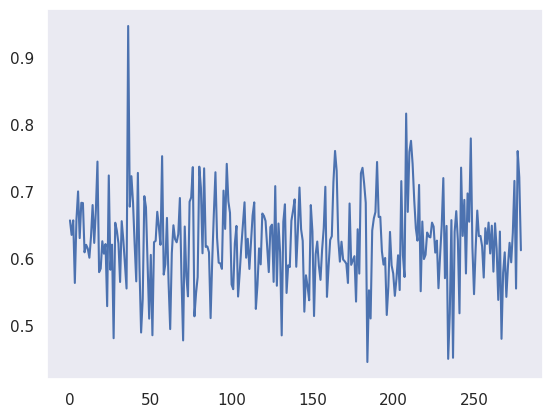

In [44]:
plt.plot(train_losses)

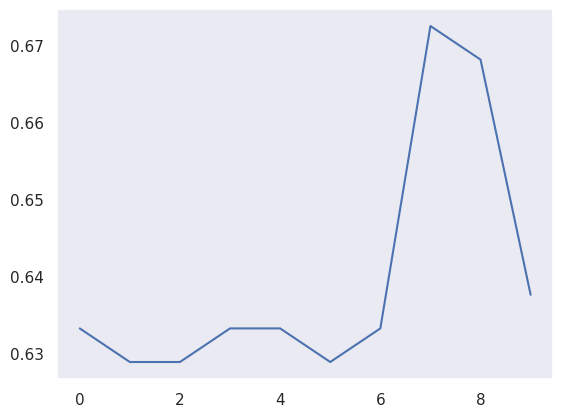

In [45]:
plt.plot(test_accuracy)

[-36.58769  -38.5688   -35.851776 -33.310863 -35.72317  -33.501846
 -36.63967  -36.077503 -36.168198 -36.596054 -37.122158 -39.23653
 -34.104553 -34.146706 -33.619038 -32.11708  -36.54176  -38.9648
 -37.285378 -38.230507 -35.751877 -34.589737 -35.818928]


/tmp/ipykernel_3807421/317335139.py:4: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())
/tmp/ipykernel_3807421/317335139.py:4: RuntimeWarning: invalid value encountered in log
  grad_log = np.log(lowbands.flatten())


(array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 3., 1., 0.,
        2., 0., 4., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1.]),
 array([-39.2365303 , -39.05854416, -38.88055801, -38.70257187,
        -38.52458572, -38.34659958, -38.16861343, -37.99062729,
        -37.81264114, -37.634655  , -37.45666885, -37.27868271,
        -37.10069656, -36.92271042, -36.74472427, -36.56673813,
        -36.38875198, -36.21076584, -36.03277969, -35.85479355,
        -35.67680359, -35.49881744, -35.3208313 , -35.14284515,
        -34.96485901, -34.78687286, -34.60888672, -34.43090057,
        -34.25291443, -34.07492828, -33.89694214, -33.71895599,
        -33.54096985, -33.3629837 , -33.18499756, -33.00701141,
        -32.82902527, -32.65103912, -32.47305298, -32.29506683,
        -32.11708069]),
 <BarContainer object of 40 artists>)

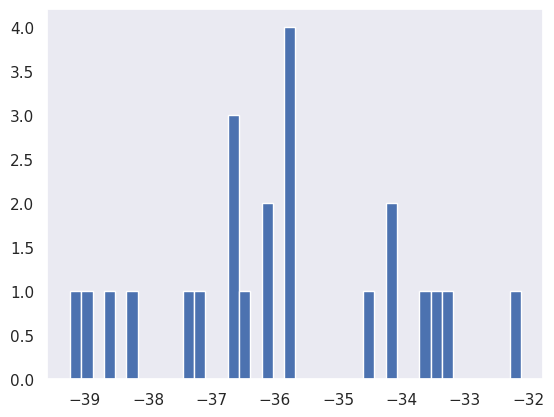

In [46]:
layer = model.fe_blocks.blocks[0].block.layer
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].grad.detach().cpu().numpy()
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
print(grad_log)
plt.hist(grad_log, bins=40)

/tmp/ipykernel_3807421/826379309.py:4: RuntimeWarning: divide by zero encountered in log
  grad_log = np.log(lowbands.flatten())


[]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

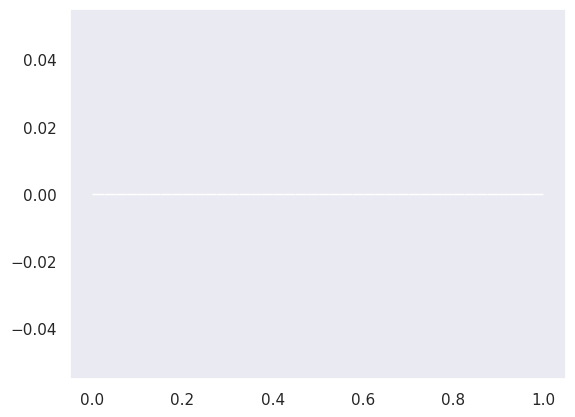

In [47]:
layer = model.fe_blocks.blocks[1].block.layer
named_params = [p for p in layer.named_parameters()]
lowbands = named_params[0][1].grad.detach().cpu().numpy()
grad_log = np.log(lowbands.flatten())
grad_log = grad_log[grad_log > float('-inf')]
print(grad_log)
plt.hist(grad_log, bins=40)

In [48]:
lowbands

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                                                                                                                              | 0.05714285714285714/50 [00:00<07:11,  8.64s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.588913
Mem before-during-after: 909396480 2486545408 20542464


  2%|███▌                                                                                                                                                                            | 1.0000000000000002/50 [00:08<05:49,  7.13s/it]


Test Epoch: 11	Accuracy: 164/224 (72%)



  2%|███▋                                                                                                                                                                            | 1.0571428571428572/50 [00:09<06:09,  7.54s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.581606
Mem before-during-after: 20539904 2487749632 20542464


  4%|███████                                                                                                                                                                         | 1.9999999999999967/50 [00:17<05:41,  7.12s/it]


Test Epoch: 12	Accuracy: 159/224 (69%)



  4%|███████▎                                                                                                                                                                         | 2.057142857142854/50 [00:18<06:02,  7.55s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.805296
Mem before-during-after: 20539904 2487749632 20542464


  6%|██████████▌                                                                                                                                                                     | 2.9999999999999933/50 [00:26<05:40,  7.24s/it]


Test Epoch: 13	Accuracy: 155/224 (68%)



  6%|██████████▊                                                                                                                                                                     | 3.0571428571428503/50 [00:27<06:00,  7.69s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.519661
Mem before-during-after: 20539904 2487749632 20542464


  8%|██████████████▏                                                                                                                                                                   | 3.99999999999999/50 [00:35<05:34,  7.27s/it]


Test Epoch: 14	Accuracy: 147/224 (64%)



  8%|██████████████▎                                                                                                                                                                  | 4.057142857142847/50 [00:36<05:50,  7.64s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.487118
Mem before-during-after: 20539904 2487749632 20542464


 10%|█████████████████▋                                                                                                                                                               | 4.999999999999987/50 [00:44<05:38,  7.53s/it]


Test Epoch: 15	Accuracy: 135/224 (59%)



 10%|█████████████████▉                                                                                                                                                               | 5.057142857142844/50 [00:45<05:53,  7.86s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.455402
Mem before-during-after: 20539904 2487749632 20542464


 12%|█████████████████████▏                                                                                                                                                           | 5.999999999999983/50 [00:53<05:10,  7.05s/it]


Test Epoch: 16	Accuracy: 160/224 (70%)



 12%|█████████████████████▌                                                                                                                                                            | 6.05714285714284/50 [00:54<05:27,  7.46s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.457853
Mem before-during-after: 20539904 2487749632 20542464


 14%|████████████████████████▉                                                                                                                                                         | 6.99999999999998/50 [01:02<05:07,  7.16s/it]


Test Epoch: 17	Accuracy: 157/224 (69%)



 14%|████████████████████████▊                                                                                                                                                       | 7.0571428571428365/50 [01:03<05:24,  7.56s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.300139
Mem before-during-after: 20539904 2487749632 20542464


 16%|████████████████████████████▎                                                                                                                                                    | 7.999999999999976/50 [01:11<05:03,  7.23s/it]


Test Epoch: 18	Accuracy: 148/224 (65%)



 16%|████████████████████████████▌                                                                                                                                                    | 8.057142857142834/50 [01:12<05:21,  7.68s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.425547
Mem before-during-after: 20539904 2487749632 20542464


 18%|███████████████████████████████▊                                                                                                                                                 | 8.999999999999973/50 [01:20<04:53,  7.15s/it]


Test Epoch: 19	Accuracy: 160/224 (70%)



 18%|████████████████████████████████▏                                                                                                                                                 | 9.05714285714283/50 [01:20<05:11,  7.60s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.307462
Mem before-during-after: 20539904 2487749632 20542464


 20%|███████████████████████████████████▌                                                                                                                                              | 9.99999999999997/50 [01:29<04:42,  7.07s/it]


Test Epoch: 20	Accuracy: 149/224 (65%)



 20%|███████████████████████████████████▍                                                                                                                                            | 10.057142857142827/50 [01:29<04:58,  7.49s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.321478
Mem before-during-after: 20539904 2487749632 20542464


 22%|██████████████████████████████████████▋                                                                                                                                         | 10.999999999999966/50 [01:38<04:38,  7.14s/it]


Test Epoch: 21	Accuracy: 161/224 (70%)



 22%|██████████████████████████████████████▉                                                                                                                                         | 11.057142857142823/50 [01:38<04:52,  7.51s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.480248
Mem before-during-after: 20539904 2487749632 20542464


 24%|██████████████████████████████████████████▏                                                                                                                                     | 11.999999999999963/50 [01:47<04:28,  7.06s/it]


Test Epoch: 22	Accuracy: 146/224 (64%)



 24%|██████████████████████████████████████████▋                                                                                                                                      | 12.05714285714282/50 [01:47<04:42,  7.46s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.342414
Mem before-during-after: 20539904 2487749632 20542464


 26%|██████████████████████████████████████████████                                                                                                                                   | 12.99999999999996/50 [01:56<04:29,  7.29s/it]


Test Epoch: 23	Accuracy: 166/224 (72%)



 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.028571428571388/50 [01:56<04:54,  7.95s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.179998
Mem before-during-after: 20539904 2487749632 20542464


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 13.999999999999956/50 [02:05<04:22,  7.30s/it]


Test Epoch: 24	Accuracy: 153/224 (67%)



 28%|█████████████████████████████████████████████████▍                                                                                                                              | 14.028571428571384/50 [02:05<04:47,  7.99s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.391938
Mem before-during-after: 20539904 2487749632 20542464


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 14.999999999999952/50 [02:14<04:14,  7.28s/it]


Test Epoch: 25	Accuracy: 161/224 (70%)



 30%|█████████████████████████████████████████████████████                                                                                                                           | 15.057142857142809/50 [02:14<04:26,  7.63s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.322454
Mem before-during-after: 20539904 2487749632 20542464


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 15.999999999999948/50 [02:23<04:03,  7.17s/it]


Test Epoch: 26	Accuracy: 157/224 (69%)



 32%|████████████████████████████████████████████████████████▌                                                                                                                       | 16.057142857142807/50 [02:23<04:16,  7.56s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.154782
Mem before-during-after: 20539904 2487749632 20542464


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 16.999999999999947/50 [02:31<03:54,  7.10s/it]


Test Epoch: 27	Accuracy: 129/224 (56%)



 34%|████████████████████████████████████████████████████████████                                                                                                                    | 17.057142857142804/50 [02:32<04:08,  7.53s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.614541
Mem before-during-after: 20539904 2487749632 20542464


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 17.999999999999943/50 [02:40<03:47,  7.11s/it]


Test Epoch: 28	Accuracy: 157/224 (69%)



 36%|████████████████████████████████████████████████████████████████▎                                                                                                                 | 18.0571428571428/50 [02:41<04:01,  7.58s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.492858
Mem before-during-after: 20539904 2487749632 20542464


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 18.99999999999994/50 [02:49<03:41,  7.14s/it]


Test Epoch: 29	Accuracy: 138/224 (60%)



 38%|███████████████████████████████████████████████████████████████████                                                                                                             | 19.057142857142797/50 [02:50<03:53,  7.55s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.336371
Mem before-during-after: 20539904 2487749632 20542464


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 19.999999999999936/50 [02:58<03:33,  7.12s/it]


Test Epoch: 30	Accuracy: 156/224 (68%)



 40%|██████████████████████████████████████████████████████████████████████▌                                                                                                         | 20.057142857142793/50 [02:59<03:45,  7.54s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.136799
Mem before-during-after: 20539904 2487749632 20542464


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 20.999999999999932/50 [03:07<03:31,  7.31s/it]


Test Epoch: 31	Accuracy: 165/224 (72%)



 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.02857142857136/50 [03:07<03:54,  8.08s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.377084
Mem before-during-after: 20539904 2487749632 20542464


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 21.99999999999993/50 [03:16<03:23,  7.25s/it]


Test Epoch: 32	Accuracy: 160/224 (70%)



 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 22.057142857142786/50 [03:16<03:32,  7.59s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.325697
Mem before-during-after: 20539904 2487749632 20542464


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 22.999999999999925/50 [03:25<03:15,  7.24s/it]


Test Epoch: 33	Accuracy: 140/224 (61%)



 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 23.057142857142782/50 [03:25<03:25,  7.63s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.138212
Mem before-during-after: 20539904 2487749632 20542464


 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 23.999999999999922/50 [03:34<03:10,  7.31s/it]


Test Epoch: 34	Accuracy: 151/224 (66%)



 48%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 24.05714285714278/50 [03:34<03:19,  7.68s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.140269
Mem before-during-after: 20539904 2487749632 20542464


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 24.99999999999992/50 [03:43<02:59,  7.17s/it]


Test Epoch: 35	Accuracy: 160/224 (70%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 25.057142857142775/50 [03:43<03:09,  7.58s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.235858
Mem before-during-after: 20539904 2487749632 20542464


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 25.999999999999915/50 [03:52<02:52,  7.19s/it]


Test Epoch: 36	Accuracy: 126/224 (55%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.028571428571343/50 [03:52<03:09,  7.89s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.777516
Mem before-during-after: 20539904 2487749632 20542464


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 26.99999999999991/50 [04:01<02:44,  7.17s/it]


Test Epoch: 37	Accuracy: 145/224 (63%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 27.057142857142768/50 [04:01<02:53,  7.58s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.729516
Mem before-during-after: 20539904 2487749632 20542464


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 27.999999999999908/50 [04:10<02:36,  7.10s/it]


Test Epoch: 38	Accuracy: 167/224 (73%)



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 28.028571428571336/50 [04:10<02:51,  7.82s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.190184
Mem before-during-after: 20539904 2487749632 20542464


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 28.999999999999904/50 [04:18<02:27,  7.02s/it]


Test Epoch: 39	Accuracy: 160/224 (70%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 29.05714285714276/50 [04:19<02:36,  7.47s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.201639
Mem before-during-after: 20539904 2487749632 20542464


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 29.9999999999999/50 [04:27<02:21,  7.07s/it]


Test Epoch: 40	Accuracy: 117/224 (51%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 30.02857142857133/50 [04:28<02:34,  7.75s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 1.258761
Mem before-during-after: 20539904 2487749632 20542464


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.999999999999897/50 [04:36<02:15,  7.11s/it]


Test Epoch: 41	Accuracy: 162/224 (71%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 31.057142857142754/50 [04:37<02:22,  7.52s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.372581
Mem before-during-after: 20539904 2487749632 20542464


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 31.999999999999893/50 [04:45<02:10,  7.26s/it]


Test Epoch: 42	Accuracy: 155/224 (68%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 32.05714285714276/50 [04:46<02:16,  7.63s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.059436
Mem before-during-after: 20539904 2487749632 20542464


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 33.000000000000014/50 [04:54<02:02,  7.21s/it]


Test Epoch: 43	Accuracy: 99/224 (43%)



 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 33.05714285714288/50 [04:55<02:10,  7.72s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 1.882713
Mem before-during-after: 20539904 2487749632 20542464


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 34.000000000000135/50 [05:03<01:54,  7.18s/it]


Test Epoch: 44	Accuracy: 165/224 (72%)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 34.057142857143/50 [05:04<02:03,  7.77s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.098944
Mem before-during-after: 20539904 2487749632 20542464


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 35.000000000000256/50 [05:12<01:49,  7.27s/it]


Test Epoch: 45	Accuracy: 152/224 (66%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 35.05714285714312/50 [05:13<01:54,  7.67s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.176749
Mem before-during-after: 20539904 2487749632 20542464


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00000000000038/50 [05:22<01:46,  7.63s/it]


Test Epoch: 46	Accuracy: 122/224 (53%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 36.02857142857181/50 [05:22<01:56,  8.34s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.514868
Mem before-during-after: 20539904 2487749632 20542464


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 37.0000000000005/50 [05:31<01:33,  7.22s/it]


Test Epoch: 47	Accuracy: 161/224 (70%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.02857142857193/50 [05:31<01:43,  7.97s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.073101
Mem before-during-after: 20539904 2487749632 20542464


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00000000000062/50 [05:40<01:28,  7.34s/it]


Test Epoch: 48	Accuracy: 126/224 (55%)



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.02857142857205/50 [05:40<01:36,  8.09s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.597143
Mem before-during-after: 20539904 2487749632 20542464


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00000000000074/50 [05:49<01:21,  7.40s/it]


Test Epoch: 49	Accuracy: 138/224 (60%)



 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.0571428571436/50 [05:50<01:24,  7.76s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.370802
Mem before-during-after: 20539904 2487749632 20542464


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 40.00000000000086/50 [05:58<01:11,  7.18s/it]


Test Epoch: 50	Accuracy: 158/224 (69%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.02857142857229/50 [05:58<01:18,  7.90s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.141628
Mem before-during-after: 20539904 2487749632 20542464


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00000000000098/50 [06:07<01:04,  7.21s/it]


Test Epoch: 51	Accuracy: 168/224 (73%)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 41.057142857143845/50 [06:08<01:07,  7.59s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.146033
Mem before-during-after: 20539904 2487749632 20542464


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 42.0000000000011/50 [06:16<00:57,  7.14s/it]


Test Epoch: 52	Accuracy: 154/224 (67%)



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 42.057142857143965/50 [06:16<00:59,  7.54s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.207557
Mem before-during-after: 20539904 2487749632 20542464


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 43.00000000000122/50 [06:25<00:50,  7.20s/it]


Test Epoch: 53	Accuracy: 168/224 (73%)



 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 43.057142857144086/50 [06:25<00:52,  7.63s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.150665
Mem before-during-after: 20539904 2487749632 20542464


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00000000000134/50 [06:34<00:43,  7.24s/it]


Test Epoch: 54	Accuracy: 164/224 (72%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 44.05714285714421/50 [06:34<00:45,  7.65s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.025282
Mem before-during-after: 20539904 2487749632 20542464


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 45.000000000001464/50 [06:43<00:36,  7.25s/it]


Test Epoch: 55	Accuracy: 175/224 (76%)



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45.028571428572896/50 [06:43<00:39,  7.96s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.087424
Mem before-during-after: 20539904 2487749632 20542464


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.000000000001585/50 [06:52<00:29,  7.27s/it]


Test Epoch: 56	Accuracy: 169/224 (74%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46.05714285714445/50 [06:52<00:29,  7.60s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.191440
Mem before-during-after: 20539904 2487749632 20542464


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.000000000001705/50 [07:01<00:21,  7.08s/it]


Test Epoch: 57	Accuracy: 173/224 (76%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47.05714285714457/50 [07:01<00:22,  7.54s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.221409
Mem before-during-after: 20539904 2487749632 20542464


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.000000000001826/50 [07:10<00:14,  7.08s/it]


Test Epoch: 58	Accuracy: 172/224 (75%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48.05714285714469/50 [07:10<00:14,  7.52s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.044576
Mem before-during-after: 20539904 2487749632 20542464


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00000000000195/50 [07:19<00:07,  7.05s/it]


Test Epoch: 59	Accuracy: 176/224 (77%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 49.05714285714481/50 [07:19<00:07,  7.46s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.010540
Mem before-during-after: 20539904 2487749632 20542464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.971428571430636/50 [07:27<00:00,  7.18s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.00000000000207/50 [07:27<00:00,  8.96s/it]


Test Epoch: 60	Accuracy: 167/224 (73%)



In [49]:
del model
gc.collect()

29